In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Volkswagen.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[df2["Fiyat"]>3000000].index, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Bora,Seri_Golf,Seri_Jetta,...,Model_2.0 TDi Exclusive,Model_2.0 TDi Highline,Model_2.0 TFSi,Model_2.0 TSi R 4Motion,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,498900,2012,90,1598,132000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,728500,2015,105,1598,224000,2.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,337500,2000,105,1595,246480,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,810000,2015,120,1598,282000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1364000,2019,150,1498,34000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_16020\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,80158.781036,5.514768e+09,74261.485342,49497.445925


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:25:50,238] A new study created in memory with name: no-name-b3a415f8-9198-4de7-87e7-bc2f3f578d7a
[I 2023-10-08 14:25:50,468] Trial 0 finished with value: 478541.7150024953 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.043097031859749856, 'max_depth': 13, 'min_child_weight': 138}. Best is trial 0 with value: 478541.7150024953.
[I 2023-10-08 14:25:50,497] Trial 7 finished with value: 695780.729160471 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.00043495571356289524, 'max_depth': 12, 'min_child_weight': 166}. Best is trial 0 with value: 478541.7150024953.
[I 2023-10-08 14:25:50,500] Trial 2 finished with value: 691559.1049783924 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.001092259388955457, 'max_depth': 7, 'min_child_weight': 81}. Best is trial 0 with value: 478541.7150024953.
[I 2023-10-08 14:25:50,500] Trial 1 finished with value: 451538.47623632906 and parameters: {'c

[I 2023-10-08 14:25:51,841] Trial 29 finished with value: 146797.94424454382 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.19698548718991368, 'max_depth': 3, 'min_child_weight': 191}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:51,859] Trial 31 finished with value: 112509.11228665127 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4733511278851586, 'max_depth': 3, 'min_child_weight': 194}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:52,029] Trial 32 finished with value: 170503.45317940786 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.16251829497942247, 'max_depth': 3, 'min_child_weight': 167}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:52,101] Trial 33 finished with value: 161195.70277031776 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.17185318807188663, 'max_depth': 3, 'min_child_w

[I 2023-10-08 14:25:53,681] Trial 60 finished with value: 139213.09649598476 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.3859590143317392, 'max_depth': 11, 'min_child_weight': 232}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:53,801] Trial 61 finished with value: 111465.10465460371 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4156217409925839, 'max_depth': 10, 'min_child_weight': 239}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:53,834] Trial 63 finished with value: 113827.81597679904 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.47402682868780777, 'max_depth': 12, 'min_child_weight': 241}. Best is trial 27 with value: 100987.35014250981.
[I 2023-10-08 14:25:53,862] Trial 64 finished with value: 105935.76248534958 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4620481498890566, 'max_depth': 10, 'min_child

[I 2023-10-08 14:25:55,614] Trial 90 finished with value: 88544.6488981491 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3969356984524828, 'max_depth': 15, 'min_child_weight': 44}. Best is trial 88 with value: 84121.94270941558.
[I 2023-10-08 14:25:55,640] Trial 92 finished with value: 89675.03534688627 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3777113875065955, 'max_depth': 15, 'min_child_weight': 53}. Best is trial 88 with value: 84121.94270941558.
[I 2023-10-08 14:25:55,640] Trial 91 finished with value: 89610.65336310925 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.38484650137539167, 'max_depth': 15, 'min_child_weight': 54}. Best is trial 88 with value: 84121.94270941558.
[I 2023-10-08 14:25:55,706] Trial 93 finished with value: 89284.18165449465 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.38083425633411033, 'max_depth': 15, 'min_child_weight': 

[I 2023-10-08 14:25:57,789] Trial 120 finished with value: 86934.7041924634 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4140650786655931, 'max_depth': 14, 'min_child_weight': 12}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:25:57,834] Trial 121 finished with value: 88126.81129641511 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2976109247118249, 'max_depth': 14, 'min_child_weight': 13}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:25:57,930] Trial 122 finished with value: 89061.1510579775 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.29700623756145006, 'max_depth': 14, 'min_child_weight': 14}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:25:57,930] Trial 123 finished with value: 89679.38267667235 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3044414924812438, 'max_depth': 14, 'min_child_weig

[I 2023-10-08 14:26:00,040] Trial 150 finished with value: 88539.52687944956 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.28031223174893494, 'max_depth': 14, 'min_child_weight': 7}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:26:00,140] Trial 151 finished with value: 90948.52089908226 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.2771316828404621, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:26:00,190] Trial 152 finished with value: 88779.2214135588 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.2788506790193756, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 109 with value: 82907.54890043018.
[I 2023-10-08 14:26:00,317] Trial 153 finished with value: 89528.2696284938 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.2744044787872987, 'max_depth': 15, 'min_child_weight'

[I 2023-10-08 14:26:02,457] Trial 180 finished with value: 82420.07296377802 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4755104076308923, 'max_depth': 15, 'min_child_weight': 23}. Best is trial 169 with value: 82028.25656208686.
[I 2023-10-08 14:26:02,628] Trial 182 finished with value: 84109.95821072567 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4924366692487811, 'max_depth': 15, 'min_child_weight': 27}. Best is trial 169 with value: 82028.25656208686.
[I 2023-10-08 14:26:02,770] Trial 181 finished with value: 85230.33934480218 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.49680157858270174, 'max_depth': 15, 'min_child_weight': 24}. Best is trial 169 with value: 82028.25656208686.
[I 2023-10-08 14:26:02,829] Trial 183 finished with value: 85366.97971110558 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49608615685686447, 'max_depth': 15, 'min_child_w

[I 2023-10-08 14:26:05,060] Trial 210 finished with value: 520505.7564374889 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.030997249418347094, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 207 with value: 82024.77129179446.
[I 2023-10-08 14:26:05,060] Trial 211 finished with value: 674009.7126076114 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0037574958924354264, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 207 with value: 82024.77129179446.
[I 2023-10-08 14:26:05,166] Trial 212 finished with value: 84409.68155716684 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3638193713090439, 'max_depth': 15, 'min_child_weight': 12}. Best is trial 207 with value: 82024.77129179446.
[I 2023-10-08 14:26:05,225] Trial 213 finished with value: 458114.76576476375 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.04445297020764435, 'max_depth': 15, 'min_ch

[I 2023-10-08 14:26:07,587] Trial 241 finished with value: 84284.91220434918 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4997230347906269, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 231 with value: 81797.24025042717.
[I 2023-10-08 14:26:07,657] Trial 240 finished with value: 88963.3185672368 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.41580576589502133, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 231 with value: 81797.24025042717.
[I 2023-10-08 14:26:07,711] Trial 242 finished with value: 584675.2991474789 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018738678375506822, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 231 with value: 81797.24025042717.
[I 2023-10-08 14:26:07,728] Trial 243 finished with value: 633227.6560037845 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.010339983971797709, 'max_depth': 7, 'min_child_wei

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 81797.2403
Best params:
	colsample_bytree: 1.0
	subsample: 0.7
	learning_rate: 0.43054000897399447
	max_depth: 6
	min_child_weight: 20


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 86624.91657793698, 'MSE': 6527319779.276468, 'RMSE': 80791.82990424507, 'MAE': 55178.206516981794}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.9315610314949401

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9236765689478066

In [17]:
marka_model = joblib.dump(final_model, "Volkswagen.pkl")

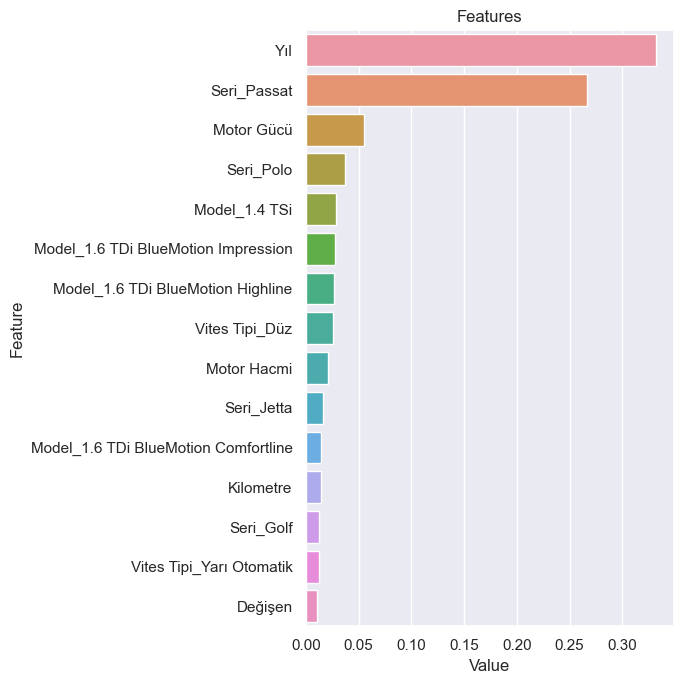

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)